## The Pill Image Recognition Challenge is a National Institutes of Health (NIH) 

the National Library of Medicine (NLM), part of NIH, seeks algorithms and software to match images of prescription oral solid-dose pharmaceutical medications (pills, including capsules and tablets). The objective of the Challenge is the development and discovery of high-quality algorithms and software that rank how well consumer images of prescription pills match reference images of pills in the authoritative NLM RxIMAGE database

### Download the data

Provided with 7000 images of pills taken as part of the NLM [Computational Photography Project for Pill Identification (C3PI) Project.](https://lhncbc.nlm.nih.gov/project/c3pi-computational-photography-project-pill-identification)

[Consumer-quality Images (9 GB)](ftp://ftp.nlm.nih.gov/nlmdata/pir/dc.zip)

[Reference Images (800 MB)](ftp://ftp.nlm.nih.gov/nlmdata/pir/dr.zip)

[Ground Truth Table (600 KB)](https://pir.nlm.nih.gov/challenge/groundTruthTable.csv) 


### Submission requirements

The requirement must be able to take as inputs directories containing arbitrary numbers of consumer and reference images, and produce an output matrix in which all of the reference images are ranked in order of how similar they are to each consumer image, as shown below.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [3]:
PATH = 'data/pill/'

In [4]:
ls {PATH}

dc_dr/                label.csv        submission_2000.csv  testcap.jpg
dc_test/              labels_test.csv  submission.csv       test_train/
dr_train/             models/          submission_lite.csv  tmp/
groundTruthTable.csv  nih_test.csv     test/                train/


### Data Visualization

In [5]:
print(len(os.listdir("data/pill/dc_dr"))) # this is a combination of both consumer and reference
print(len(os.listdir("data/pill/dc_test"))) # amount of images in test set

7001
5000


In [6]:
trainFrame = pd.read_csv("data/pill/groundTruthTable.csv")

In [7]:
trainFrame.shape # csv data info shape

(10000, 2)

In [8]:
len(trainFrame["ref_images"].unique()) # no of unique labels

2000

In [9]:
trainFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
ref_images     10000 non-null object
cons_images    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [10]:
all_labels = trainFrame['ref_images']
ids_counted_and_sorted = pd.DataFrame({'ref_images': all_labels}).groupby('ref_images')\
                            .size().reset_index().sort_values(0, ascending=False)
ids_counted_and_sorted.head(10)

,ref_images,0
1337,00555-9008-67_PART_1_OF_2_CHAL10_SF_252F928C.jpg,6
1739,52544-0291-28_PART_1_OF_4_CHAL10_SF_5C1E2E51.jpg,6
1830,60505-0146-00_PART_1_OF_1_CHAL10_SB_46292339.jpg,6
1354,00555-9014-67_PART_1_OF_2_CHAL10_SB_952FCACE.jpg,6
1355,00555-9014-67_PART_1_OF_2_CHAL10_SF_952FCACE.jpg,6
1831,60505-0146-00_PART_1_OF_1_CHAL10_SF_46292339.jpg,6
1738,52544-0291-28_PART_1_OF_4_CHAL10_SB_5C1E2E51.jpg,6
1336,00555-9008-67_PART_1_OF_2_CHAL10_SB_252F928C.jpg,6
1328,00555-1055-86_PART_1_OF_1_CHAL10_SB_E33071D3.jpg,5
1329,00555-1055-86_PART_1_OF_1_CHAL10_SF_E33071D3.jpg,5


In [16]:
consumer_imgs = len(trainFrame['cons_images'].unique()) #print number of unique IDs
     
print(f'Number of Consumer Images: {consumer_imgs}')

Number of Consumer Images: 5000


In [17]:
trainFrame['cons_images'].value_counts().head(10)

521.jpg     2
3547.jpg    2
4144.jpg    2
1137.jpg    2
430.jpg     2
4000.jpg    2
1819.jpg    2
538.jpg     2
2061.jpg    2
2072.jpg    2
Name: cons_images, dtype: int64

In [18]:
trainFrame['cons_images'].value_counts().head(10) #most common tags

521.jpg     2
3547.jpg    2
4144.jpg    2
1137.jpg    2
430.jpg     2
4000.jpg    2
1819.jpg    2
538.jpg     2
2061.jpg    2
2072.jpg    2
Name: cons_images, dtype: int64

### Train the Model

In [20]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [21]:
labels_csv = f'{PATH}groundTruthTable.csv'
n = len(list(open(labels_csv))) -1
val_idxs = get_cv_idxs(n)

In [22]:
n

10000

In [23]:
val_idxs

array([6252, 4684, 1731, ..., 7853, 1095, 6929])

In [24]:
len(val_idxs)

2000

In [25]:
f_model = resnet18
sz = 256
bs = 64

In [26]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down + transforms_side_on, max_zoom=1.05)

In [27]:
data = ImageClassifierData.from_csv(PATH, 'dc_dr', labels_csv, test_name='dc_test', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [28]:
print(data.val_dl)

In [29]:
len(val_idxs)

2000

In [30]:
data.val_dl

In [31]:
learn = ConvLearner.pretrained(f_model, data)

 98%|█████████▊| 122/125 [01:14<00:01,  1.65it/s, loss=113] 

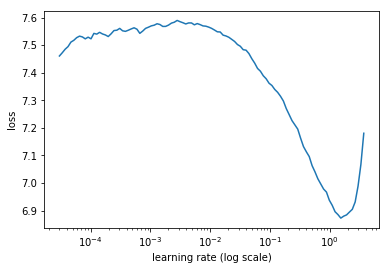

In [32]:
lrf=learn.lr_find()
learn.sched.plot()

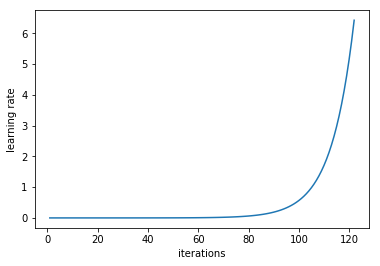

In [33]:
learn.sched.plot_lr()

In [34]:
data = data.resize(int(sz*1.3), 'tmp')

 29%|██▉       | 2334/8000 [00:09<00:22, 247.20it/s]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [35]:
lr = 0.1

In [36]:
learn.fit(lr, 2)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                   
    0      4.857998   3.494423   0.2335    
    1      3.116273   2.072246   0.461                      



In [37]:
learn.precompute=False
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.00906    1.389159   0.6605    
    1      1.855143   1.121107   0.7055                     
    2      1.421831   0.863252   0.771                      
    3      1.567348   0.919248   0.742                      
    4      1.272349   0.627453   0.823                      
    5      0.956407   0.452256   0.873                       
    6      0.843246   0.432062   0.888                       



[array([0.43206]), 0.888]

In [38]:
learn.save('04_15_nih_first')

### Additional training

In [39]:
learn.unfreeze()

In [40]:
lrs=np.array([1e-4,1e-3,1e-2])

In [41]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.797192   0.832349   0.7565    
    1      1.179433   0.59899    0.813                      
    2      0.889804   0.475504   0.8615                      
    3      0.872588   0.461158   0.8635                      
    4      0.733386   0.369091   0.9                         
    5      0.620815   0.309035   0.914                       
    6      0.582321   0.297733   0.921                       



[array([0.29773]), 0.921]

In [44]:
learn.save('04_15_nih_second')

In [45]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.583352   0.28006    0.9265    
    1      0.594281   0.25671    0.9265                      
    2      0.489395   0.234712   0.9385                      



[array([0.23471]), 0.9385]

In [46]:
learn.save('04_15_nih_third')

In [47]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.491856   0.223848   0.933     
    1      0.503684   0.209206   0.946                       
    2      0.42849    0.194366   0.9485                      



[array([0.19437]), 0.9485]

In [48]:
learn.save('04_15_nih_forth')

In [49]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.437336   0.192239   0.9425    
    1      0.421649   0.1815     0.9455                      
    2      0.381535   0.170435   0.9485                      



[array([0.17044]), 0.9485]

In [50]:
learn.save('04_15_nih_fifth')

In [51]:
classes = np.array(data.classes, dtype=str)

In [52]:
classes

array(['1000.jpg', '1002.jpg', '1004.jpg', '1010.jpg', '1016.jpg', '1017.jpg', '1023.jpg', '1033.jpg',
       '1034.jpg', '1035.jpg', '1037.jpg', '1039.jpg', '1040.jpg', '1042.jpg', '1043.jpg', '1046.jpg',
       '1049.jpg', '105.jpg', '1052.jpg', '1059.jpg', '1064.jpg', '1067.jpg', '1069.jpg', '1078.jpg',
       '1079.jpg', '1083.jpg', '1087.jpg', '1088.jpg', '1093.jpg', '1095.jpg', '1098.jpg', '110.jpg',
       '1105.jpg', '1113.jpg', '1118.jpg', '1123.jpg', '1131.jpg', '1134.jpg', '1138.jpg', '1141.jpg',
       '1146.jpg', '1153.jpg', '1158.jpg', '1174.jpg', '1193.jpg', '1196.jpg', '1204.jpg', '1206.jpg',
       '1207.jpg', '1214.jpg', '1216.jpg', '1224.jpg', '1230.jpg', '1236.jpg', '1238.jpg', '1239.jpg',
       '126.jpg', '1271.jpg', '1272.jpg', '1273.jpg', '128.jpg', '1286.jpg', '129.jpg', '1295.jpg',
       '1298.jpg', '1302.jpg', '1306.jpg', '1316.jpg', '1318.jpg', '1321.jpg', '1328.jpg', '133.jpg',
       '1331.jpg', '1334.jpg', '1338.jpg', '1340.jpg', '1343.jpg', '1345.jpg', 

### Output

In [53]:
learn.load('04_15_nih_fifth')

In [54]:
data.trn_dl.dataset.n

8000

In [55]:
data.val_dl.dataset.n

2000

In [56]:
len(data.test_ds.fnames)

5000

In [57]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
preds.shape

(2000, 1000)

In [58]:
sample_df = pd.read_csv('data/pill/submission_2000.csv') #using a smaller file because preds shape is 2000 by 1000

In [59]:
fnames = sample_df[['cons_images']].values

In [60]:
fnames

array([['0.jpg'],
       ['1.jpg'],
       ['10.jpg'],
       ...,
       ['2796.jpg'],
       ['2797.jpg'],
       ['2798.jpg']], dtype=object)

In [61]:
values = np.hstack([fnames, preds])

In [62]:
values

array([['0.jpg', 4.463062452941813e-07, 9.792538548936136e-06, ..., 3.910687329522489e-09,
        2.3870779131129893e-08, 4.463610281391084e-08],
       ['1.jpg', 5.247610488368082e-07, 1.6046766177169047e-05, ..., 4.048772872522477e-09,
        1.5477713333211796e-08, 2.1652146742212608e-08],
       ['10.jpg', 1.3456223086905084e-06, 4.185644684184808e-06, ..., 3.9102552307213045e-09,
        6.463851320859249e-08, 1.9524367900203288e-08],
       ...,
       ['2796.jpg', 2.5528940073016315e-11, 2.104100574329415e-11, ..., 2.845509661231205e-10,
        1.1012954992395407e-09, 3.1017943769029444e-10],
       ['2797.jpg', 1.174067926212885e-10, 2.7069696310888514e-12, ..., 9.156249976965958e-13,
        4.2189536586523246e-11, 1.2989806279228855e-11],
       ['2798.jpg', 7.183902778207241e-11, 2.810170444868948e-13, ..., 1.88429675508639e-12,
        1.3023662877309494e-11, 6.99107167555918e-13]], dtype=object)

In [79]:
submission_df = pd.DataFrame(values, preds)

In [91]:
submission_df.to_csv('nih_two.csv', index=False) #this produces csv file 2000 by 1000 with preds

In [92]:
submission_df.all()

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
971     True
972     True
973     True
974     True
975     True
976     True
977     True
978     True
979     True
980     True
981     True
982     True
983     True
984     True
985     True
986     True
987     True
988     True
989     True
990     True
991     True
992     True
993     True
994     True
995     True
996     True
997     True
998     True
999     True
1000    True
Length: 1001, dtype: bool

In [84]:
#Need to create a file with the following headings
sample_df = pd.read_csv('data/pill/submission_2000.csv')
sample_df.head(1)

,cons_images,00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg,00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SB_3E1E1F50.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SF_3E1E1F50.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SB_361E1B30.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SF_361E1B30.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SB_3F1E1F80.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SF_3F1E1F80.jpg,00002-3250-30_PART_1_OF_1_CHAL10_SB_431E21C1.jpg,...,00173-0178-55_PART_1_OF_1_CHAL10_SB_AF18D7A6.jpg,00173-0178-55_PART_1_OF_1_CHAL10_SF_AF18D7A6.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SB_251912B8.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SF_251912B8.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SB_97194BBA.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SF_97194BBA.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SB_A01C5002.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SF_A01C5002.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SB_461DA30D.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SF_461DA30D.jpg
0,0.jpg,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [81]:
submission_template = pd.read_csv(sample_df)
submission_dataframe = pd.DataFrame(columns=submission_template.columns)
submission_dataframe.head()

,cons_images,00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg,00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SB_3E1E1F50.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SF_3E1E1F50.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SB_361E1B30.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SF_361E1B30.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SB_3F1E1F80.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SF_3F1E1F80.jpg,00002-3250-30_PART_1_OF_1_CHAL10_SB_431E21C1.jpg,...,00173-0178-55_PART_1_OF_1_CHAL10_SB_AF18D7A6.jpg,00173-0178-55_PART_1_OF_1_CHAL10_SF_AF18D7A6.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SB_251912B8.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SF_251912B8.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SB_97194BBA.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SF_97194BBA.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SB_A01C5002.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SF_A01C5002.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SB_461DA30D.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SF_461DA30D.jpg


In [82]:
# Prepare submission
submission_dataframe['cons_images'] = submission_df['cons_images'].tolist()
submission_dataframe.head(1)

KeyError: 'cons_images'

In [78]:
submission_dataframe.to_csv('nih_two.csv', index=False)
submission_dataframe.head(10)

,cons_images,00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg,00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SB_3E1E1F50.jpg,00002-3229-30_PART_1_OF_1_CHAL10_SF_3E1E1F50.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SB_361E1B30.jpg,00002-3238-30_PART_1_OF_1_CHAL10_SF_361E1B30.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SB_3F1E1F80.jpg,00002-3239-30_PART_1_OF_1_CHAL10_SF_3F1E1F80.jpg,00002-3250-30_PART_1_OF_1_CHAL10_SB_431E21C1.jpg,...,00173-0178-55_PART_1_OF_1_CHAL10_SB_AF18D7A6.jpg,00173-0178-55_PART_1_OF_1_CHAL10_SF_AF18D7A6.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SB_251912B8.jpg,00173-0556-02_PART_1_OF_1_CHAL10_SF_251912B8.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SB_97194BBA.jpg,00173-0561-00_PART_1_OF_1_CHAL10_SF_97194BBA.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SB_A01C5002.jpg,00173-0562-00_PART_1_OF_1_CHAL10_SF_A01C5002.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SB_461DA30D.jpg,00173-0565-04_PART_1_OF_1_CHAL10_SF_461DA30D.jpg
0,0.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1001.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1002.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1003.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1004.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1005.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
